# FortBrasil


Este jupyter notebook visa responder a questão 3 do case teste prático referente ao processo seletivo para cientista de dados da FortBrasil.

## Informações sobre o case

Uma empresa de crédito taiwanês está querendo prever o pagamento próxima fatura dos seus clientes. Tendo esse objetivo em mente, os cientistas de dados dessa empresa coletaram informações cadastrais dos clientes e informações sobre as suas faturas e seus pagamentos. 

Esses dados seriam utilizado para criação de estratégias de comunicação para clientes que tivessem **alta probabilidade de não pagar as suas próximas faturas**, objetivando a diminuição da inadimplência. 

**OBS: Ja é comprovado por essa empresa que enviar comunicação faz com que os clientes lembrem mais de pagar suas faturas.**

Utilizando a base de dados "questao3_creditcard.csv" e o seus conhecimentos técnicos e de negócio, responda as seguintes perguntas: 

**2.1 - Que tipo de problema estamos enfrentando e qual técnica você utilizaria para resolver esse problema?**

O problema que estamos atacando é o problema da inadimplência. A inadimplência financeira é definida como o não pagamento de bens ou serviços até sua data de vencimento. Esse é um problema recorrente que incomoda diversos empresários de todos segmentos e, principalemente em épocas de crise,  deve ser atacado.

Para identificar os clientes inadimplentes utilizados **algoritmos de classificação** e verificado qual o modelo obtido fornece o melhor resultado em identificar clientes que são inandimplentes ou não, por meio das métricas de classificação.


**2.2 - Se você só pudesse enviar comunicação para 10% dos clientes devivo ao alto custo, para quais clientes abaixo você enviaria? Explique sua resposta. Utilizar os clientes da base "questao33_creditcard_clientes.csv"** 

O grupo de clientes que foram escolhidos para receber foram salvos no arquivo **comunicacao_clientes.csv**

##### Explicações mais detalhadas e a justificativa da escolha desse grupo de clientes para receber a mensagem são apresentadas ao longo desse arquivo.

# 
**Atributos das bases enviadas**
* Y: Pagamento da Próxima Fatura (1: Sim, 0: Não) 
* X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
* X2: Gender (1 = male; 2 = female). 
* X3: Educação (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* X4: Marital status (1 = married; 2 = single; 3 = others). 
* X5: Age (year). 
* X6: X11: History of past payment. We tracked the past monthly payment records (from April to September, 2019) as follows: X6 = the repayment status in September, 2019; X7 = the repayment status in August, 2019; ... ; -2: No consumption; 0: The use of revolving credit X11: the repayment status in April, 2019. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ... ; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2019; X13 = amount of bill statement in August, 2019; ... ; X17 = amount of bill statement in April, 2019. 
* X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2019; X19 = amount paid in August, 2019; ... ;X23 = amount paid in April, 2019.

In [1]:
# Importando as bibliotecas úteis para resolver o case

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, average_precision_score, recall_score

pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize']=20,20

In [3]:
# Lendo os arquivos csv com informações dos clientes

creditcard = pd.read_csv(r"bases/questao3_creditcard.csv", sep=";")
clientes = pd.read_csv(r"bases/questao33_creditcard_clientes.csv", sep=";")

## Pré-processamento

Iremos inspecionar os dois dataframes fazer as limpezas e tratamento dos dados

In [4]:
creditcard.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [5]:
# Dimensão do dataframe

creditcard.shape

(27278, 24)

In [6]:
sumary_creditcard = pd.DataFrame({'columns': creditcard.columns, 
                                  'type': creditcard.dtypes,
                                  'nan values': creditcard.isna().sum(),
                                  'nan values (%)': (creditcard.isna().sum()/creditcard.shape[0])*100,
                                  'unique values': creditcard.nunique()}).reset_index(drop=True)
sumary_creditcard

,columns,type,nan values,nan values (%),unique values
0,X1,object,0,0.0,81
1,X2,object,0,0.0,3
2,X3,object,0,0.0,8
3,X4,object,0,0.0,5
4,X5,object,0,0.0,57
5,X6,object,0,0.0,12
6,X7,object,0,0.0,12
7,X8,object,0,0.0,12
8,X9,object,0,0.0,12
9,X10,object,0,0.0,11


In [7]:
sumary_clientes = pd.DataFrame({'columns': clientes.columns, 
                                  'type': clientes.dtypes,
                                  'nan values': clientes.isna().sum(),
                                  'nan values (%)': (clientes.isna().sum()/creditcard.shape[0])*100,
                                  'unique values': clientes.nunique()}).reset_index(drop=True)
sumary_clientes

,columns,type,nan values,nan values (%),unique values
0,X1,object,0,0.0,62
1,X2,object,0,0.0,3
2,X3,object,0,0.0,8
3,X4,object,0,0.0,5
4,X5,object,0,0.0,47
5,X6,object,0,0.0,11
6,X7,object,0,0.0,10
7,X8,object,0,0.0,10
8,X9,object,0,0.0,10
9,X10,object,0,0.0,9


**Inconsistências nos dataframes:**

1) Os nomes das colunas estão na primeira linha;

2) Todas as colunas são do tipo 'object'.

Primeiras trativas: Ajustar o nome das colunas e converter todas as features para inteiro

In [8]:
def labels_colunas(df):
    
    #Ajuste do nome das colunas
    
    columns = np.array(df.iloc[0])
    df.columns = columns
    df.drop(0, axis=0, inplace=True)
    return df

In [9]:
def converte_object_to_int(df):
    
    #Ajuste de tipo de variável
    
    df1 = df.astype('int64')
    return df1

In [10]:
df_default_payment = labels_colunas(creditcard)
df_default_payment = converte_object_to_int(df_default_payment)


df = labels_colunas(clientes)
df = converte_object_to_int(df)

Resumo do dataset creditcard reestruturado

In [11]:
sumary_creditcard = pd.DataFrame({'columns': df_default_payment.columns, 
                                  'type': df_default_payment.dtypes,
                                  'nan values':df_default_payment.isna().sum(),
                                  'nan values (%)': (df_default_payment.isna().sum()/creditcard.shape[0])*100,
                                  'unique values': df_default_payment.nunique()}).reset_index(drop=True)
sumary_creditcard

,columns,type,nan values,nan values (%),unique values
0,LIMIT_BAL,int64,0,0.0,80
1,SEX,int64,0,0.0,2
2,EDUCATION,int64,0,0.0,7
3,MARRIAGE,int64,0,0.0,4
4,AGE,int64,0,0.0,56
5,PAY_0,int64,0,0.0,11
6,PAY_2,int64,0,0.0,11
7,PAY_3,int64,0,0.0,11
8,PAY_4,int64,0,0.0,11
9,PAY_5,int64,0,0.0,10


Resumo do dataset clientes refatorado

In [12]:
sumary_clientes = pd.DataFrame({'columns': df.columns, 
                                  'type': df.dtypes,
                                  'nan values': df.isna().sum(),
                                  'nan values (%)': (df.isna().sum()/creditcard.shape[0])*100,
                                  'unique values': df.nunique()}).reset_index(drop=True)
sumary_clientes

,columns,type,nan values,nan values (%),unique values
0,LIMIT_BAL,int64,0,0.0,61
1,SEX,int64,0,0.0,2
2,EDUCATION,int64,0,0.0,7
3,MARRIAGE,int64,0,0.0,4
4,AGE,int64,0,0.0,46
5,PAY_0,int64,0,0.0,10
6,PAY_2,int64,0,0.0,9
7,PAY_3,int64,0,0.0,9
8,PAY_4,int64,0,0.0,9
9,PAY_5,int64,0,0.0,8


O primeiro tratamento será codificar a feature AGE (Idade) em labels:

0 -> AGE <= 18

1 ->  18 < AGE =< 30

2 ->  30 < AGE =< 40

3 ->  40 < AGE =< 60

4 ->  AGE > 60

In [13]:
df_default_payment['AGE_cat'] = pd.cut(
                            df_default_payment['AGE'], [0, 18, 30, 40, 60, 200], 
                            labels=[0, 1, 2, 3, 4])

Nesse momento iremos verificar a correlação entre as features. A correlação entre as features deve ser, idealmente, baixa. Isso é devido ao fato que uma baixa correlação indica que essas features explicam características diferentes do modelo. Além disso, uma alta correlação entre as features resulta no problema de multicolinearidade. 

Não menos importante é observar a correlação entre as features e a variável target: quanto maior a correlação entre a feature a variável alvo mais essa feature consegue influenciar positivamente no modelo.

In [14]:
df_default_payment

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment,AGE_cat
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,2
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,2
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,100000,1,1,2,38,0,-1,-1,0,0,0,3042,1427,102996,70626,69473,55004,2000,111784,4000,3000,2000,2000,0,2
27274,80000,1,2,2,34,2,2,2,2,2,2,72557,77708,79384,77519,82607,81158,7000,3500,0,7000,0,4000,1,2
27275,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,3
27276,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,2


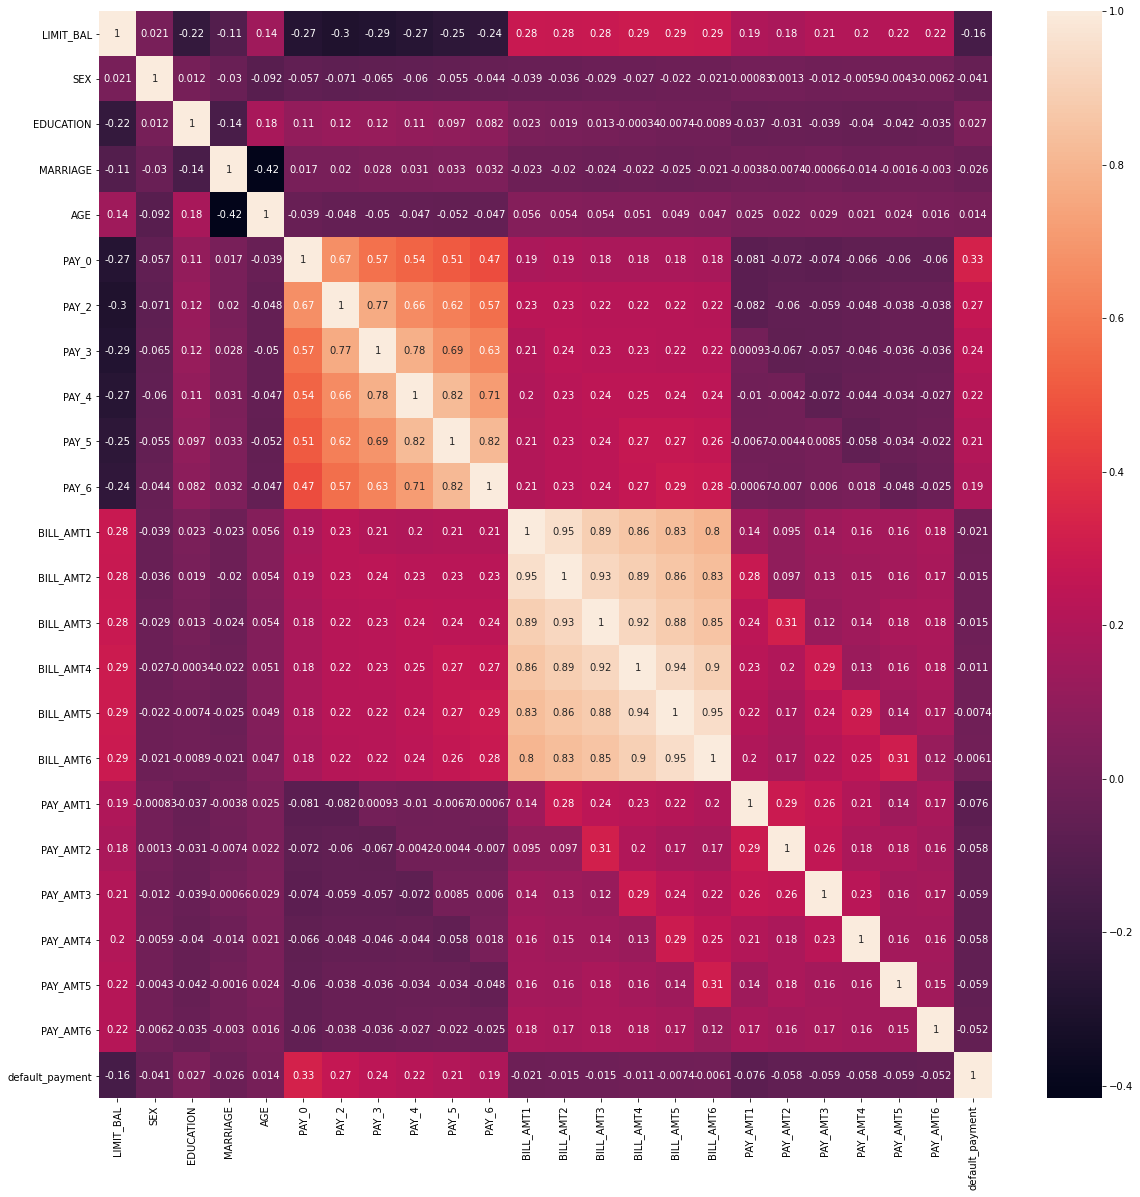

In [15]:
sns.heatmap(df_default_payment.corr(), annot=True);

As features com correlação superior a 0.7 serão excluidas

In [16]:
colunas_corr =['PAY_2', 'PAY_4', 'PAY_6',
               'BILL_AMT2', 'BILL_AMT3', 
               'BILL_AMT4', 'BILL_AMT5', 
               'BILL_AMT6']

df_default_payment.drop(columns=colunas_corr, axis=1, inplace=True)

Além disso, vamos verificar os Componentes Principais do dataset utilizando a técnica PCA (Análise de Componentes Principais). Os dados serão reduzidos para duas dimensões para termos um auxilio visual de como os dados estão distribuídos.

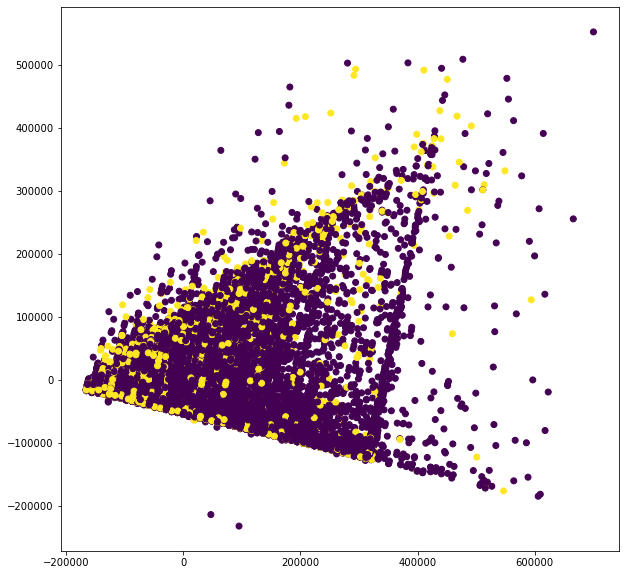

In [17]:
pca = PCA(n_components=2)
pca.fit(df_default_payment)
r2 = pca.transform(df_default_payment)

plt.rcParams['figure.figsize']=10,10
target = [0,1]
plt.scatter(r2[:,0], r2[:,1], c=df_default_payment['default_payment'].apply(lambda x: target[x]))

Como esperado há uma grande quantidade dados classificados como 0 (inadimplentes) e, além disso, não é possível verificar uma separação clara entre os grupos.

# Modelagem

In [18]:
# Abaixo estão a lsita de classificadores que serão utilizados para identidificar clientes que são ou não inadimplentes.

classifiers = [
               GaussianNB(),
               LogisticRegression(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(n_estimators=100, random_state=0),
               RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
               XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5,
                            min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                            objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)


]

Apesar de não ser possível perceber uma clara separação de grupos por meio do PCA, será aplicado um algoritmo de cluesterização (kmeans) para captar a similaridade entre grupos existentes no dataframe. O resultado da clusterização se tornará uma feature do modelo para ajudá-lo a performar melhor.

In [19]:
X = df_default_payment.drop('default_payment', axis=1)
y = df_default_payment['default_payment']

Quando se trabalha com modelos baseados em distâncias (como é o caso do Kmeans), uma boa prática é fazer a normalização dos dados

In [20]:
#Normalização dos dados
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

Primeiro iremos aplicar o Elbow Method para identificar a quantidade de clusters adequada para o conjunto de dados

1 12661.014367845995
2 6101.846201238732
3 4863.2513635976475
4 4011.7016314946336
5 3603.3994671685105
6 3431.6593150408767
7 3156.3928297566945
8 3026.7259846182214
9 2915.623528210458
10 2783.5721972452125


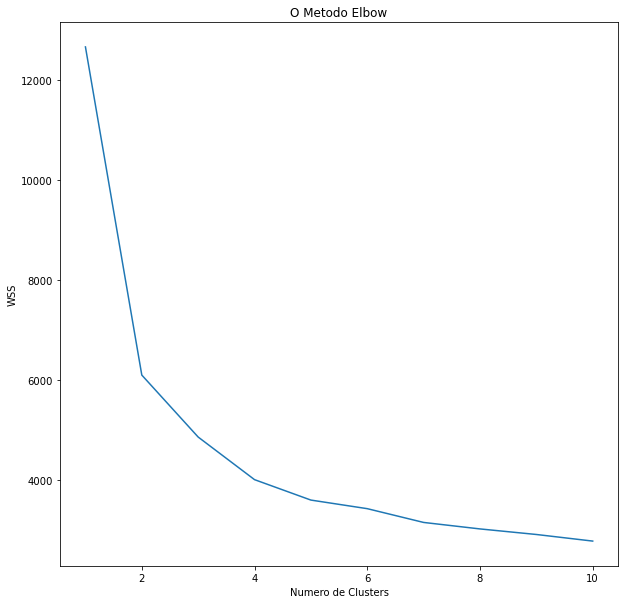

In [21]:
# Método Elbow para definir a quantidade de clusters
wcss = []
 
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(X_scaled)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_) 
    
plt.rcParams['figure.figsize']=10,10
plt.plot(range(1, 11), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

O número adequado de agrupamentos escolhido foi 5 (mais que 5 clusters o WSS diminui lentamente)

In [22]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_scaled)
kmeans.labels_
y_kmeans = kmeans.predict(X_scaled)

In [23]:
# Montando um novo dataset com os dados normalizados e a feature referente ao cluster
X_kmeans = pd.DataFrame(X_scaled, columns = X.columns)
X_kmeans['default_payment'] = y
X_kmeans['default_payment'] = X_kmeans['default_payment'].fillna(0)
X_kmeans['y_kmeans'] = y_kmeans

Agora iremos verificar a distribuição dos clientes classificados como bons pagodores (1) no dataframe

In [24]:
X_kmeans

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_3,PAY_5,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,AGE_cat,default_payment,y_kmeans
0,0.012658,1.0,0.333333,0.333333,0.051724,0.4,0.1,0.0,0.185767,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4
1,0.139241,1.0,0.333333,0.666667,0.086207,0.1,0.2,0.2,0.184418,0.000000,0.000594,0.001125,0.001610,0.000000,0.003783,0.000000,1.0,4
2,0.101266,1.0,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.213525,0.001738,0.000891,0.001125,0.001610,0.002345,0.009458,0.333333,1.0,1
3,0.050633,1.0,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.232980,0.002290,0.001199,0.001350,0.001771,0.002506,0.001892,0.333333,0.0,1
4,0.050633,0.0,0.333333,0.333333,0.620690,0.1,0.1,0.2,0.190923,0.002290,0.021779,0.011248,0.014493,0.001615,0.001284,0.666667,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27272,0.113924,0.0,0.166667,0.666667,0.293103,0.2,0.1,0.2,0.184813,0.002290,0.066370,0.004499,0.004831,0.004689,0.003783,0.333333,0.0,2
27273,0.088608,0.0,0.333333,0.666667,0.224138,0.4,0.4,0.4,0.261002,0.008013,0.002078,0.000000,0.011272,0.000000,0.007566,0.333333,0.0,2
27274,0.177215,0.0,0.500000,0.666667,0.379310,0.1,0.1,0.2,0.183323,0.002103,0.002094,0.010121,0.000208,0.000000,0.000000,0.666667,1.0,0
27275,0.025316,0.0,0.333333,0.666667,0.275862,0.6,0.4,0.2,0.185386,0.000000,0.000000,0.024746,0.006763,0.004689,0.005864,0.333333,0.0,2


In [25]:
for i in range(0,5):
    X_kmeans[X_kmeans['y_kmeans']==i]['default_payment'].value_counts()
    print('='*20)
    print('Quantidade de inadimplência por cluster')
    print('cluster', i)
    print(X_kmeans[X_kmeans['y_kmeans']==i]['default_payment'].value_counts())

Quantidade de inadimplência por cluster
cluster 0
0.0    4011
1.0    1241
Name: default_payment, dtype: int64
Quantidade de inadimplência por cluster
cluster 1
0.0    4572
1.0    1157
Name: default_payment, dtype: int64
Quantidade de inadimplência por cluster
cluster 2
0.0    4318
1.0    1282
Name: default_payment, dtype: int64
Quantidade de inadimplência por cluster
cluster 3
0.0    3238
1.0     937
Name: default_payment, dtype: int64
Quantidade de inadimplência por cluster
cluster 4
0.0    5081
1.0    1440
Name: default_payment, dtype: int64


O cluster 0 é composto por cerca de 30,99% de clientes classificados como 1

O cluster 1 é composto por cerca de 25,30% de clientes classificados como 1

O cluster 2 é composto por cerca de 29,25% de clientes classificados como 1

O cluster 3 é composto por cerca de 28,93% de clientes classificados como 1

O cluster 4 é composto por cerca de 38,34% de clientes classificados como 1

Saber qual cluster tem a menor incidência de clientes classificados como 1 (ou seja, tem o maior percentual de clientes classificados com inadimplentes (0)) será útil quando for necessário limitar os clientes que receberão os emails.

Nesse caso o cluster 1 será analisado com mais detalhes posteriormente

Agora iremos fazer a classificação do modelo. Para isso iremos rodar um pipeline para testar os modelos que foram instanciados anteriormente.

Nessa parte, atacaremos o problema de duas formas distintas para identificar qual modelo irá nos auxiliar na melhor tomada de decisão.

1) Qualidade do modelo em identificar clientes que são classificados como bons pagadores.

In [26]:
list_roc = []
list_recall = []
list_f1 = []
list_avg = []

clfs = []
for clf in classifiers:
    clf.fit(X_scaled, y)
    name = clf.__class__.__name__

    print('='*20)
    print(name)

    print('====Resumo===')
    roc = cross_val_score(clf, X_kmeans.drop('default_payment', axis=1), y, cv=5, scoring='roc_auc').mean()
    recall = cross_val_score(clf, X_kmeans.drop('default_payment', axis=1),  y, cv=5, scoring='recall').mean()
    avg_precision = cross_val_score(clf, X_kmeans.drop('default_payment', axis=1),  y, cv=5, scoring='average_precision').mean()
    f1 = cross_val_score(clf,X_kmeans.drop('default_payment', axis=1), y, cv=5, scoring='f1').mean()

    summary = f'ROC_AUC: {roc}, \nRecall Score: {recall} \nF1 Socre: {f1}\nAverage Precision: {avg_precision}'
    print(summary)

    list_roc.append(avg_precision)
    list_roc.append(roc)
    list_recall.append(recall)
    list_f1.append(f1)
    clfs.append(name)

GaussianNB
====Resumo===
ROC_AUC: 0.7331686683188431, 
Recall Score: 0.8326145372588456 
F1 Socre: 0.41714783264115296
Average Precision: 0.5032558963469795


C:\Users\natal\anaconda3\envs\Fortbrasil\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\natal\anaconda3\envs\Fortbrasil\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

LogisticRegression
====Resumo===


C:\Users\natal\anaconda3\envs\Fortbrasil\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\natal\anaconda3\envs\Fortbrasil\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

C:\Users\natal\anaconda3\envs\Fortbrasil\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\natal\anaconda3\envs\Fortbrasil\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

ROC_AUC: 0.7214239360949787, 
Recall Score: 0.23257978977088462 
F1 Socre: 0.351365950165191
Average Precision: 0.5104009713830224
KNeighborsClassifier
====Resumo===
ROC_AUC: 0.6977975557352536, 
Recall Score: 0.3507782074656681 
F1 Socre: 0.43138213930837643
Average Precision: 0.41380757847325433
GradientBoostingClassifier
====Resumo===
ROC_AUC: 0.7792300438282005, 
Recall Score: 0.36315798797055593 
F1 Socre: 0.4729710707628719
Average Precision: 0.5572549861731801
RandomForestClassifier
====Resumo===
ROC_AUC: 0.7720071171203188, 
Recall Score: 0.3232064164302475 
F1 Socre: 0.4426293676327722
Average Precision: 0.5542869618222438
XGBClassifier
====Resumo===
ROC_AUC: 0.7804142176749551, 
Recall Score: 0.36365276494618903 
F1 Socre: 0.4728135165660441
Average Precision: 0.5597645394826601


Nessa análise, a métrica escolhida prioritariamente é um valor elevado de Recall, penalizando os falsos negativos uma vez que o custo de enviar a mensagem é muito elevado. É pior que o modelo indique que o cliente é inadimplente (0), quando na verdade ele não é. Ou seja, um baixo recall, para esse caso, faz com que o dinheiro investido nessa campanha seja gasto com clientes que tem alta probabilidade de pagamento.

Então por essa abordagem o modelo escolhido foi o **GaussianNB**

2) A segunda abordagem é baseada em considerar o vetor target invertido (indimplentes classificados como 1 e e bons pagadores classificados como 0). Devido a característica dos algoritmos de métricas de classificação serem formulados considerando que a variável de interesse é classificada 1 (que é o oposto que temos aqui), portanto para facilitar a análise dos resultados, iremos trocar a classificação do modelo. Criando uma coluna 'y_barra' em que 1 indica os clientes inadimplentes e 0 os bons pagadores.

In [27]:
y_barra = ~y.astype(bool)
y_barra = y_barra.astype(int)

In [ ]:
list_roc = []
list_recall = []
list_f1 = []
list_avg = []

clfs = []
for clf in classifiers:
    clf.fit(X_scaled, y)
    name = clf.__class__.__name__

    print('='*20)
    print(name)

    print('====Resumo===')
    roc = cross_val_score(clf, X_kmeans.drop('default_payment', axis=1), y_barra, cv=5, scoring='roc_auc').mean()
    recall = cross_val_score(clf, X_kmeans.drop('default_payment', axis=1),  y_barra, cv=5, scoring='recall').mean()
    avg_precision = cross_val_score(clf, X_kmeans.drop('default_payment', axis=1),  y_barra, cv=5, scoring='average_precision').mean()
    f1 = cross_val_score(clf, X_kmeans.drop('default_payment', axis=1), y_barra, cv=5, scoring='f1').mean()

    summary = f'ROC_AUC: {roc}, \nRecall Score: {recall} \nF1 Socre: {f1}\nAverage Precision: {avg_precision}'
    print(summary)

    list_roc.append(avg_precision)
    list_roc.append(roc)
    list_recall.append(recall)
    list_f1.append(f1)
    clfs.append(name)

GaussianNB
====Resumo===
ROC_AUC: 0.7331842405078434, 
Recall Score: 0.38168342024997426 
F1 Socre: 0.5319436679820437
Average Precision: 0.8807792041881413
LogisticRegression
====Resumo===


C:\Users\natal\anaconda3\envs\Fortbrasil\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\natal\anaconda3\envs\Fortbrasil\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

C:\Users\natal\anaconda3\envs\Fortbrasil\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\natal\anaconda3\envs\Fortbrasil\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

ROC_AUC: 0.7214239360949787, 
Recall Score: 0.9744095336489241 
F1 Socre: 0.8884446861642509
Average Precision: 0.8703783249499611
KNeighborsClassifier
====Resumo===
ROC_AUC: 0.6977975557352536, 
Recall Score: 0.9212967391210183 
F1 Socre: 0.8746445799996687
Average Precision: 0.8581636912463615
GradientBoostingClassifier
====Resumo===


Nesse caso, estamos mais interessados na métrica de precisão, que penaliza mais os falsos positivos. Para classificar um cliente como inandimplente (1) é necessário que ele esteja correto, mesmo que alguns clientes inadimplentes (1) sejam classificados como bons pagadores (0). Um modelo mais preciso diminui a possibilidade de gastar o dinheiro investido na campanha enviando mensagens para clientes classificados como bons pagadores.

Para essa abordagem escolhi o XGBClassifier

Para a decisão de qual modelo escolher, vou fazer uma análise baseada na matriz de confusão dos dois modelos.

In [ ]:
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

In [ ]:
gnb = GaussianNB()

In [30]:
gnb.fit(X_train_gnb, y_train_gnb)
y_pred_gnb = gnb.predict(X_test_gnb)

In [ ]:
plt.rcParams['figure.figsize']=5,5
plot_confusion_matrix(gnb, X_test_gnb, y_test_gnb)

In [ ]:
average_precision_score(y_test_gnb, y_pred_gnb)

In [ ]:
recall_score(y_test_gnb, y_pred_gnb)

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5,
                            min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                            objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [ ]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_scaled, y_barra, test_size=0.33, random_state=42)

In [ ]:
xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xgb.predict(X_test_xgb)

In [ ]:
plt.rcParams['figure.figsize']=20,20
plot_confusion_matrix(xgb, X_test_xgb, y_test_xgb)

In [ ]:
average_precision_score(y_test_xgb, y_pred_xgb)

In [ ]:
recall_score(y_test_xgb, y_pred_xgb)

Pela matriz de confusão e sem aplicar o cross validation percebe-se que as métricas de precisão e recall do XGBClassifier são superiores. Por essa razão, será utilizado este classificador 

## Dados de validação

Tratamento dos dados de validação:
    
1) Criando feature de categoria de idade

In [ ]:
df['AGE_cat'] = pd.cut(
                df['AGE'], [0, 18, 30, 40, 60, 200], 
                labels=[0, 1, 2, 3, 4])

2) Excluindo features com alta correlação

In [ ]:
df.drop(columns=colunas_corr, axis=1, inplace=True)

3) Normalização dos dados

In [ ]:
X_scaled_val = scaler.transform(df)

4) Criação das features baseadas na clusterização

In [ ]:
X_kmeans_val = pd.DataFrame(X_scaled_val, columns = X.columns)
X_kmeans_val['y_kmeans'] = kmeans.predict(df)

## Treinamento do modelo

In [ ]:
xgb_val = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5,
                            min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                            objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [ ]:
xgb_val.fit( X_kmeans.drop('default_payment', axis=1), y_barra)
y_proba = xgb_val.predict_proba(X_kmeans_val)

In [ ]:
y_proba

In [ ]:
X_kmeans_val['prob_0'] = y_proba[:,0]
X_kmeans_val['prob_1'] = y_proba[:,1]

O predict_proba indica a probabilidade da variável em estudo ser de determinada classe. Ele retorna vetores de dimensão (mxn) em que m é o número de linhas do dataset e n é o número de casos em estudo. A soma entre os termos da mesma linha é 1.

In [ ]:
#Probabilidade de ser 0
plt.rcParams['figure.figsize']=10,10
X_kmeans_val['prob_0'].hist(bins=20)

In [ ]:
#Probabilidade de nao ser 1
plt.rcParams['figure.figsize']=10,10
X_kmeans_val['prob_1'].hist(bins=20)

Devemos levar em conta que estamos utilizando a lógica invertida da original (inadimplentes(1) e bons pagadores (0)) para a escolha dos clientes que receberão as mensagens, pois o modelo performou melhor dessa maneira.

Portanto, estamos interessados em clientes com alta probabilidade de serem inadimplentes, ou seja, alta possibilidade de serem classificados como 1 e que estão dentro do cluster 1.

O threshold da probabilidade de serem classificados como 1 será obtido empiricamente para que o número de clientes seja menor ou igual aos 10% estipulados.

O clientes classificados como os que receberão a mensagem da equipe de comunicação serão salvos no arquivo comunicacao_clientes.csv

In [ ]:
cluster1 = X_kmeans_val[X_kmeans_val['y_kmeans']==1]

In [ ]:
comunicacao_clientes = cluster1[cluster1['prob_1']>0.945]
comunicacao_clientes.shape

In [ ]:
comunicacao_clientes.to_csv('comunicacao_clientes.csv', index = False)